# Прогнозирование и борьба с оттоком клиентов сети фитнес-центров

В рамках разработки стратегии взаимодействия с клиентами сети фитнес-центров было принято решение о приложить максимум усилий для борьбы с оттоком клиентов и повышению лояльности пользователей.

**Для этого перед аналитиками поставлены задачи:**

•	научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;

•	сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;

•	проанализировать основные признаки, наиболее сильно влияющие на отток;

•	сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
      
      1) выделить целевые группы клиентов;

      2) предложить меры по снижению оттока;

      3) определить другие особенности взаимодействия с клиентами.

Для анализа был предоставлен csv-файл, который включает в себя данные клиента за предыдущий до проверки факта оттока месяц, а также информацию на основе журнала посещений, покупок и данные о текущем статусе абонемента клиента.

**Ход исследования:**
1.	Загрузка и изучение данных
2.	Исследовательский анализ данных (EDA)
  
   2.1	Изучение средних значений и стандартного отклонения;
   
   2.2	Визуализация признаков тех кто ушел и тех, кто остался
   
   2.3	Матрица корреляций признаков клиентов.

3.	Модель прогнозирования оттока клиентов

4.	Кластеризация клиентов
   
   4.1 Стандартизация
   
   4.2 Матрица расстояний и дендограмма
   
   4.3 Обучение модели на основании алгоритма K-Means 
   
   4.4 Средние значения признаков для кластеров
   
   4.5 Распределения признаков для кластеров
   
   4.6 Доля оттока по кластерам

5.	Общие выводы и рекомендации

## Загрузка и изучение данных

In [1]:
import warnings
#warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, silhouette_score
from sklearn.ensemble import RandomForestClassifier
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

from plotly import graph_objects as go

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('gym_churn.csv')
df.head()

gender  Near_Location  Partner  Promo_friends  Phone  Contract_period  \
0       1              1        1              1      0                6   
1       0              1        0              0      1               12   
2       0              1        1              0      1                1   
3       0              1        1              1      1               12   
4       1              1        1              1      1                1   

   Group_visits  Age  Avg_additional_charges_total  Month_to_end_contract  \
0             1   29                     14.227470                    5.0   
1             1   31                    113.202938                   12.0   
2             0   28                    129.448479                    1.0   
3             1   33                     62.669863                   12.0   
4             0   26                    198.362265                    1.0   

   Lifetime  Avg_class_frequency_total  Avg_class_frequency_current_month  \
0         3                   0.020398                           0.000000   
1         7                   1.922936                           1.910244   
2         2                   1.859098                           1.736502   
3         2                   3.205633                           3.357215   
4         3                   1.113884                           1.120078   

   Churn  
0      0  
1      0  
2      0  
3      0  
4      0

In [3]:
# приведем названия колонок к нижнему регистру
df.columns = df.columns.str.lower()
df.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

In [4]:
# некоторые колонки имеют слишком длинные имена, которые будут плозо смотреться в визуализации, сократим их
df.rename(columns = {'avg_additional_charges_total' : 'avg_charges', 
                      'month_to_end_contract' : 'end_month', 
                     'avg_class_frequency_total' : 'avg_class_t',
                     'avg_class_frequency_current_month' : 'avg_class_cm', 
                     'promo_friends' : 'friends'}, inplace = True) 

In [5]:
df.head()

gender  near_location  partner  friends  phone  contract_period  \
0       1              1        1        1      0                6   
1       0              1        0        0      1               12   
2       0              1        1        0      1                1   
3       0              1        1        1      1               12   
4       1              1        1        1      1                1   

   group_visits  age  avg_charges  end_month  lifetime  avg_class_t  \
0             1   29    14.227470        5.0         3     0.020398   
1             1   31   113.202938       12.0         7     1.922936   
2             0   28   129.448479        1.0         2     1.859098   
3             1   33    62.669863       12.0         2     3.205633   
4             0   26   198.362265        1.0         3     1.113884   

   avg_class_cm  churn  
0      0.000000      0  
1      1.910244      0  
2      1.736502      0  
3      3.357215      0  
4      1.120078      0

## Исследовательский анализ данных (EDA)

### Изучение средних значений и стандартного отклонения

Проверим данные на отсутствующие признаки, посмотрим средние значения и стандартные отклонения

In [6]:
# изучим разброс данных, средние значения и стандартные отклонения
df.describe().T

count        mean        std        min        25%  \
gender           4000.0    0.510250   0.499957   0.000000   0.000000   
near_location    4000.0    0.845250   0.361711   0.000000   1.000000   
partner          4000.0    0.486750   0.499887   0.000000   0.000000   
friends          4000.0    0.308500   0.461932   0.000000   0.000000   
phone            4000.0    0.903500   0.295313   0.000000   1.000000   
contract_period  4000.0    4.681250   4.549706   1.000000   1.000000   
group_visits     4000.0    0.412250   0.492301   0.000000   0.000000   
age              4000.0   29.184250   3.258367  18.000000  27.000000   
avg_charges      4000.0  146.943728  96.355602   0.148205  68.868830   
end_month        4000.0    4.322750   4.191297   1.000000   1.000000   
lifetime         4000.0    3.724750   3.749267   0.000000   1.000000   
avg_class_t      4000.0    1.879020   0.972245   0.000000   1.180875   
avg_class_cm     4000.0    1.767052   1.052906   0.000000   0.963003   
churn            4000.0    0.265250   0.441521   0.000000   0.000000   

                        50%         75%         max  
gender             1.000000    1.000000    1.000000  
near_location      1.000000    1.000000    1.000000  
partner            0.000000    1.000000    1.000000  
friends            0.000000    1.000000    1.000000  
phone              1.000000    1.000000    1.000000  
contract_period    1.000000    6.000000   12.000000  
group_visits       0.000000    1.000000    1.000000  
age               29.000000   31.000000   41.000000  
avg_charges      136.220159  210.949625  552.590740  
end_month          1.000000    6.000000   12.000000  
lifetime           3.000000    5.000000   31.000000  
avg_class_t        1.832768    2.536078    6.023668  
avg_class_cm       1.719574    2.510336    6.146783  
churn              0.000000    1.000000    1.000000

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender             4000 non-null int64
near_location      4000 non-null int64
partner            4000 non-null int64
friends            4000 non-null int64
phone              4000 non-null int64
contract_period    4000 non-null int64
group_visits       4000 non-null int64
age                4000 non-null int64
avg_charges        4000 non-null float64
end_month          4000 non-null float64
lifetime           4000 non-null int64
avg_class_t        4000 non-null float64
avg_class_cm       4000 non-null float64
churn              4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


In [8]:
# заменим типы данных в столбцах
# сдлаем столбцы с ограниченным вариантом ответов булевыми
df[['gender','near_location', 'partner', 'friends', 'phone', 'group_visits', 'churn']] = \
            df[['gender','near_location', 'partner', 'friends', 'phone', 'group_visits', 'churn']].astype('bool')
# заменим номер месяца на целое число
df['end_month'] = df['end_month'].astype('int')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender             4000 non-null bool
near_location      4000 non-null bool
partner            4000 non-null bool
friends            4000 non-null bool
phone              4000 non-null bool
contract_period    4000 non-null int64
group_visits       4000 non-null bool
age                4000 non-null int64
avg_charges        4000 non-null float64
end_month          4000 non-null int32
lifetime           4000 non-null int64
avg_class_t        4000 non-null float64
avg_class_cm       4000 non-null float64
churn              4000 non-null bool
dtypes: bool(7), float64(3), int32(1), int64(3)
memory usage: 230.6 KB


In [9]:
# проверим на пропуски
df.duplicated().sum()

0

In [10]:
# посмотрим на средние показатели по группам
df.groupby('churn').mean()

gender  near_location   partner   friends     phone  contract_period  \
churn                                                                           
False  0.510037       0.873086  0.534195  0.353522  0.903709         5.747193   
True   0.510839       0.768143  0.355325  0.183789  0.902922         1.728558   

       group_visits        age  avg_charges  end_month  lifetime  avg_class_t  \
churn                                                                           
False      0.464103  29.976523   158.445715   5.283089  4.711807     2.024876   
True       0.268615  26.989632   115.082899   1.662582  0.990575     1.474995   

       avg_class_cm  
churn                
False      2.027882  
True       1.044546

Данные очень разнообразны. Для анализа предоставлены 4 тысячи записей
Более 84,5% клиентов фитнес-центра живет или работает рядом. Интересно, что примерно половина посетителей (48,6%) – работники фирм-партнеров, а порядка 30% пришли по акции «приведи друга».
Сроки абонементов сильно варьируются, они бывают от 1 до 12 месяцев, среднее значение – 4,6 месяцев.
Средний возраст клиентов 29 лет.
Средняя частота посещений 1,87 раз в неделю, однако есть те, кто ходит в зал по 6 раз в неделю. Максимальная выручка с допуслуг в центрах более 550 рублей, в среднем - 147. 
Средний отток -26,5% , какие клиенты «отваливаются чаще всего нам предстоит узнать. Для начала изучим распределение признаков по группам - ушедшие и оставшиеся

### Визуализация признаков тех кто ушел и тех, кто остался

In [11]:
# разделим признаки на булевые и числовые
bool_columns = [] 
dig_columns = []

for col in (df.columns.tolist()):
    if df[col].dtype == 'bool':
        bool_columns.append(col)
    else:
        dig_columns.append(col)
        
print('Булевые:', bool_columns, '\n\nЧисловые:', dig_columns)

Булевые: ['gender', 'near_location', 'partner', 'friends', 'phone', 'group_visits', 'churn'] 

Числовые: ['contract_period', 'age', 'avg_charges', 'end_month', 'lifetime', 'avg_class_t', 'avg_class_cm']


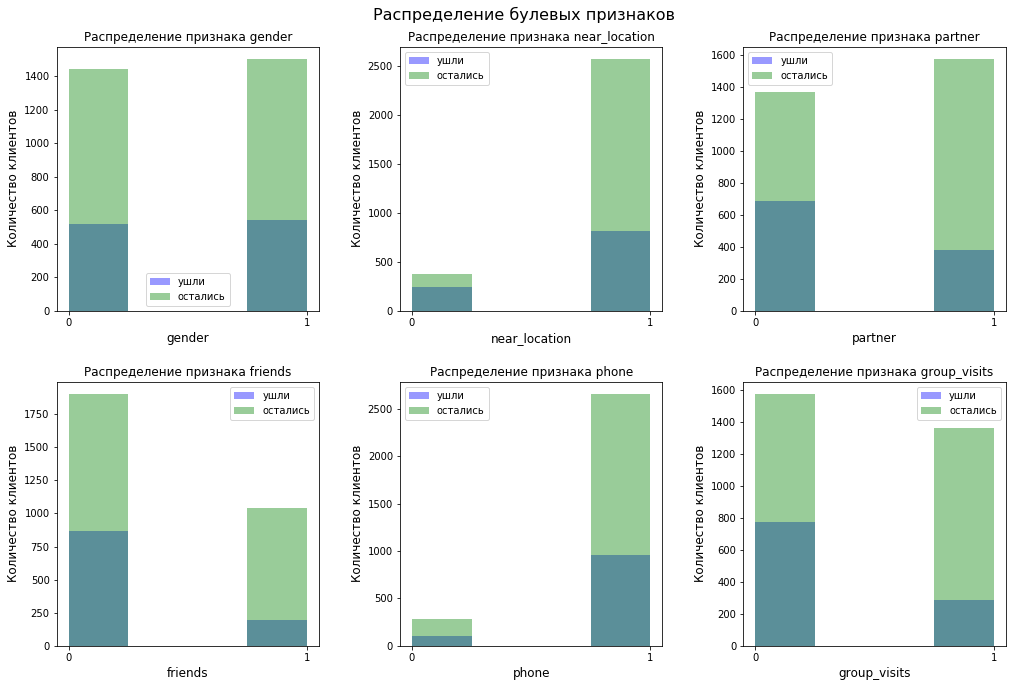

In [12]:
# изучим распределение булевых признаков
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
axes_list = [item for sublist in axes for item in sublist]
fig.tight_layout(pad=5.0)
fig.suptitle('Распределение булевых признаков', fontsize=16)
for feature in bool_columns:
    ax = axes_list.pop(0)
    sns.distplot(df.query('churn == 1')[feature].astype(int), bins=4, ax=ax, kde=False, color='b',label='ушли')
    sns.distplot(df.query('churn == 0')[feature].astype(int), bins=4, ax=ax, kde=False, color='g',label='остались')
    ax.set_title("Распределение признака "+feature)
    ax.set_xticks([0,1])
    ax.set_xlabel(feature, fontsize=12)
    ax.set_ylabel('Количество клиентов', fontsize=12)
    ax.legend()
    if len(axes_list) == 0:
        break

Распределение полов по группам примерно одинаковое, среди тех, кто остался значительно больше тех, кто жавет рядом с клубом.
Среди посетителей-партнеров значительно большая часть осталась в клубе, также как и среди участников акции "приведи друга".
Большинство оставили свой телефон для контакта, однако на отток это, по всей видимости, не влияет.
Важное замечание - клиенты, которые часто ходят на групповые тренировки охотнее остаются в клубе!

**Посмотрим на числовые признаки**

In [13]:
# разделим выборки на ушедших клиентов, и тех, кто остался
churn = df.query('churn == 1')
loyal = df.query('churn == 0')

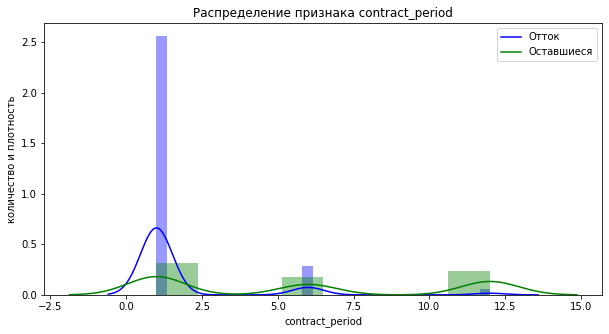

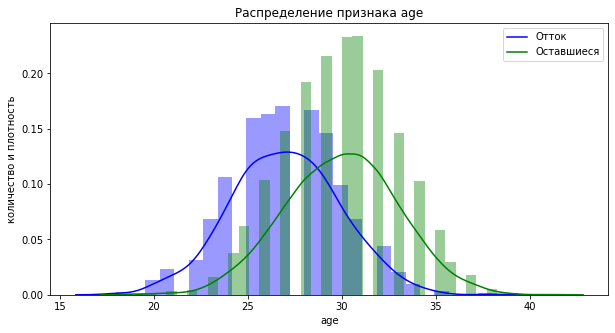

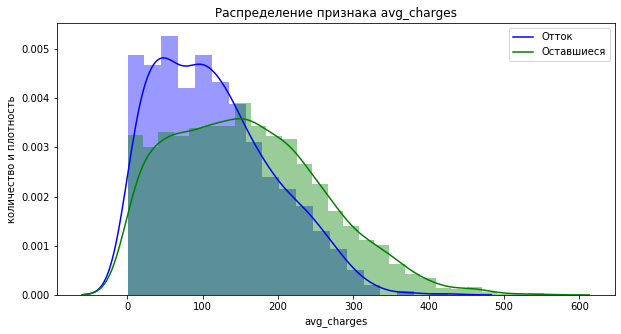

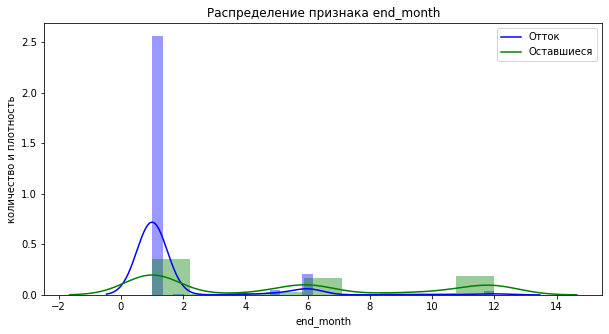

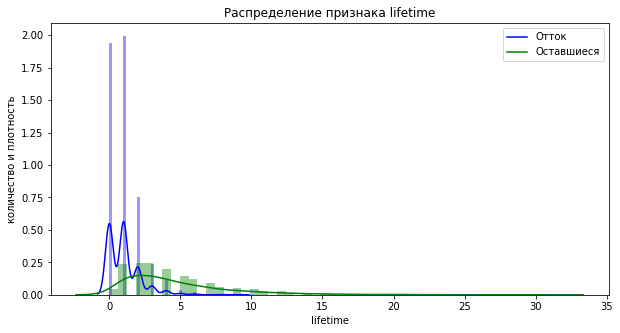

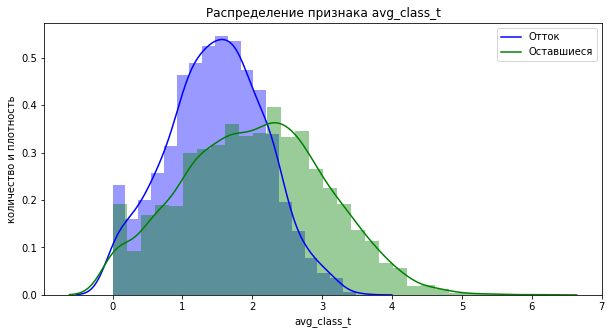

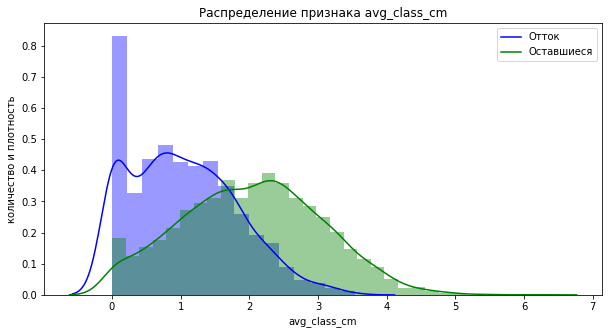

In [14]:
for column in dig_columns: 
  plt.figure(figsize=(10,5)) 
  plt.title("Распределение признака "+column)
  plt.ylabel("количество и плотность")
  sns.distplot(churn[column], color='b')
  sns.distplot(loyal[column], color='g')
  plt.legend(['Отток', 'Оставшиеся'])
  plt.show()

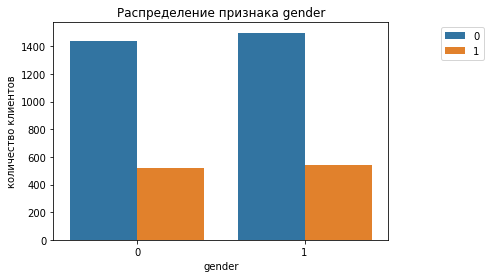

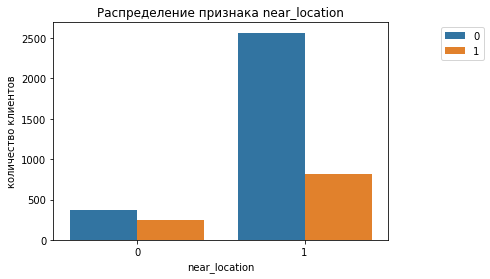

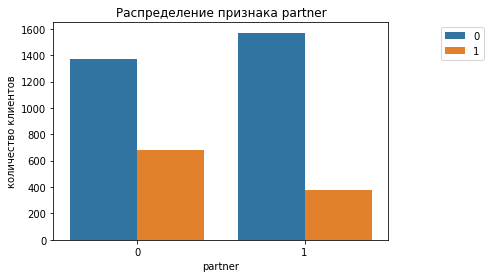

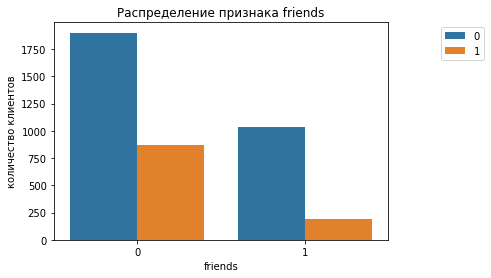

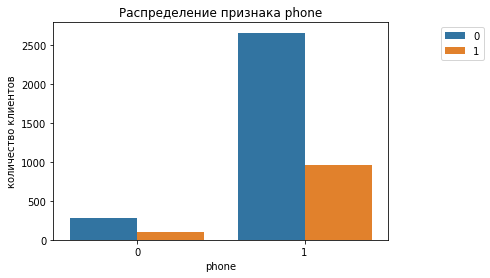

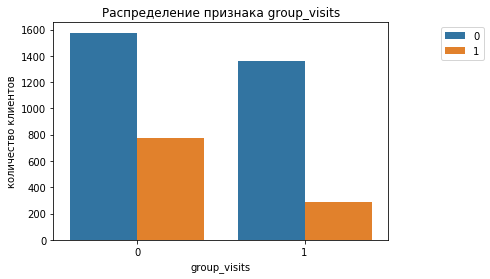

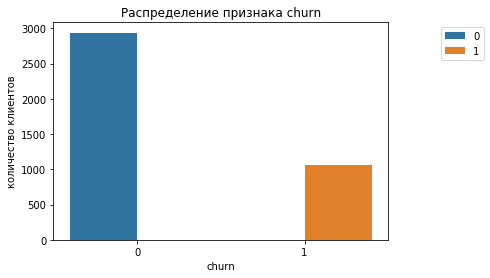

In [15]:
df[bool_columns] = df[bool_columns].astype('int')

# посмотрим на распределение булевых признаков

#fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,10))

fig, ax = plt.subplots()
for column in bool_columns:
    plt.title("Распределение признака "+column)
    sns.countplot(data=df, x=column, hue='churn')
    plt.xlabel(column)
    plt.ylabel("количество клиентов")
    plt.legend(bbox_to_anchor=(1.3, 1))
    plt.show()

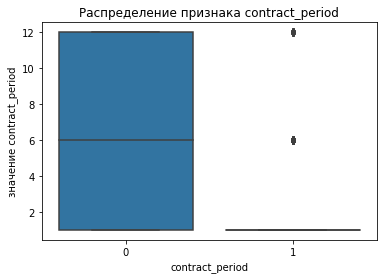

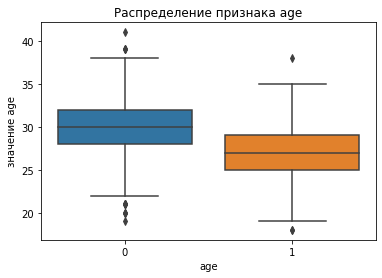

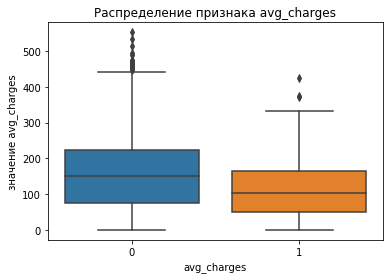

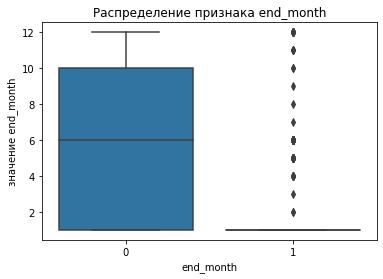

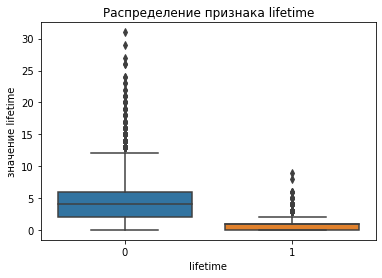

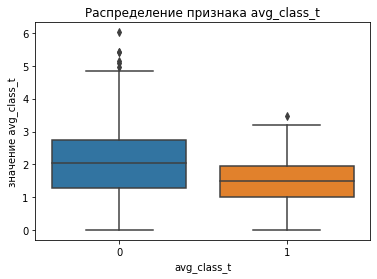

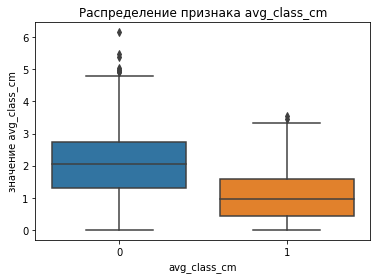

In [16]:
# boxplot для числовых значений
#fig, axes = plt.subplots(ncols=2)
fig, axes = plt.subplots()

for column in dig_columns:
    plt.title("Распределение признака "+column)
    sns.boxplot(x='churn', y=column, data=df)
    plt.xlabel(column)
    plt.ylabel('значение '+column)
    plt.show()

Показатель длительности договора отражает вполне закономерную динамику - самый большой отток у пользователей, которые берут карту на месяц (возможно, это пробные, акционные карты). Наиболее стабильные клиенты - те, у кого длительные контракты.

Диаграмма возраста не менее интересна, средний возраст ушедших клиентов - 25-26 лет, а вот остаются чаще более взрослые посетители.

Абсолютное большинство посетителей клуба тратит дополнительно не более 350 рублей, при этом среди потративших до 150 рублей отток больше.

Отток значительно выше среди тех, у кого остался всего 1 месяц. Возможно, это как раз те, кто купил месяцный абонемент. Чем больше месяцев осталось, тем выше мотивация остаться.

Чем дольше клиенты ходят в клуб, тем выше шанс того, что они останутся, самый большой отток у тех, кто занимается менее 2 меяцев.

Общее количество посещений распределено пости нормально, при этом интересно, что значительно выше отток у тех, кто посещает занятия от 1 до 2 раз в неделю, те же, кто ходит чаще, чаще и остаются, вероятно, они более мотивированы. Количество занятий в последний месяц показывает похожую закономерность, те, кто часто ходит чаще остаются.

### Матрица корреляций признаков клиентов

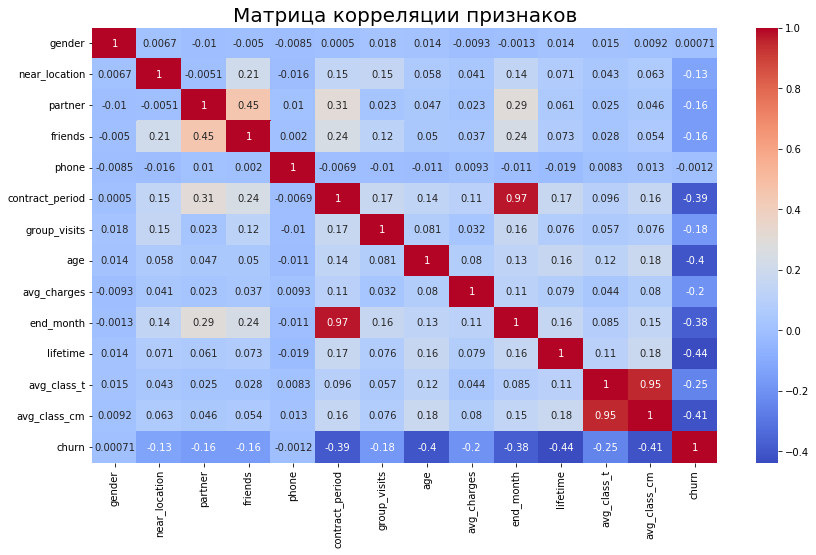

In [17]:
m_corr = df.corr()
plt.figure(figsize=(14,8))
sns.heatmap(m_corr, annot = True, square=False, cmap='coolwarm')
plt.title('Матрица корреляции признаков', fontsize = 20)
plt.show()

В среднем признаки мало коррелируют друг с другом. 
Можно отметить срок контракта и количество месяцев до конца договора, а также частоту посещений, их взаимосвязь логична.

Совсем никак не влияют на отток наличие телефона (что мы уже отмечали) и пол клиентов.

**Вывод**

Для анализа представлена таблица в 4 тысяи записей. Данные не имеют дубликатов и пропусков признаков. Нами были заменены некоторые колонки на булевые.

В ходе первичного изучения данных мы отметили, что гораздо чаще уходят те клиенты, которые живут вдалеке от клуба, имеют короткий срок контракта, ходят на занятия реже 2 раз в неделю и редко посещают групповые занятия. При этом работники компаний-пратнеров и участники акции "друзей" чаще остаются в клубе, что значит, что данные маркетинговые усилия не напрасны. Интересно, что чредний возраст оттока ниже, чем тех, кто остался.

Попробуем спрогнозировать отток.

## Модель прогнозирования оттока клиентов

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце

In [18]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = df.drop('churn', axis=1)
y = df['churn']

In [19]:
# разделим модель на обучающую и валидационную выборки и стандартизируем их
# так как у нас нет привязки к одному времени, используем случайное разбиение

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train) 

X_test_st = scaler.transform(X_test) 

Обучим модель на train-выборке двумя способами: логистической регрессией и случайным лесом.

In [20]:
# напишем и применим фунцию, которая получает модель и выводит метрики 
def show_metrics(name, mdl):
    mdl.fit(X_train_st, y_train)
    y_pred = mdl.predict(X_test_st)
    print("Модель прогнозирования -", name)

    accuracy = accuracy_score(y_test, y_pred)
    print("Доля правильных ответов: Accuracy =", accuracy)
    precision = precision_score(y_test, y_pred)
    print("Точность: precision =", precision)
    recall = recall_score(y_test, y_pred)
    print("Полнота: recall =", recall, '\n')

model = LogisticRegression(random_state=0)
show_metrics('логистическая регрессия', model)

model = RandomForestClassifier(n_estimators = 100, random_state=0)
show_metrics('случайный лес', model)

Модель прогнозирования - логистическая регрессия
Доля правильных ответов: Accuracy = 0.9225
Точность: precision = 0.8541666666666666
Полнота: recall = 0.8282828282828283 

Модель прогнозирования - случайный лес
Доля правильных ответов: Accuracy = 0.915
Точность: precision = 0.8385416666666666
Полнота: recall = 0.8131313131313131 



**Вывод**

Доля правильных ответов у логистической регрессии немного выше - 0,922 против 0,915 случайного леса, точность также выше: у логистической регрессии 0,854, у леса 0,839. Выше и полнота: 0,828 против 0,813. Таким образом логистическая регрессия сработала чуть лучше.

## Кластеризация клиентов

### Стандартизация данных

In [21]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

### Матрица расстояний и дендрограмма

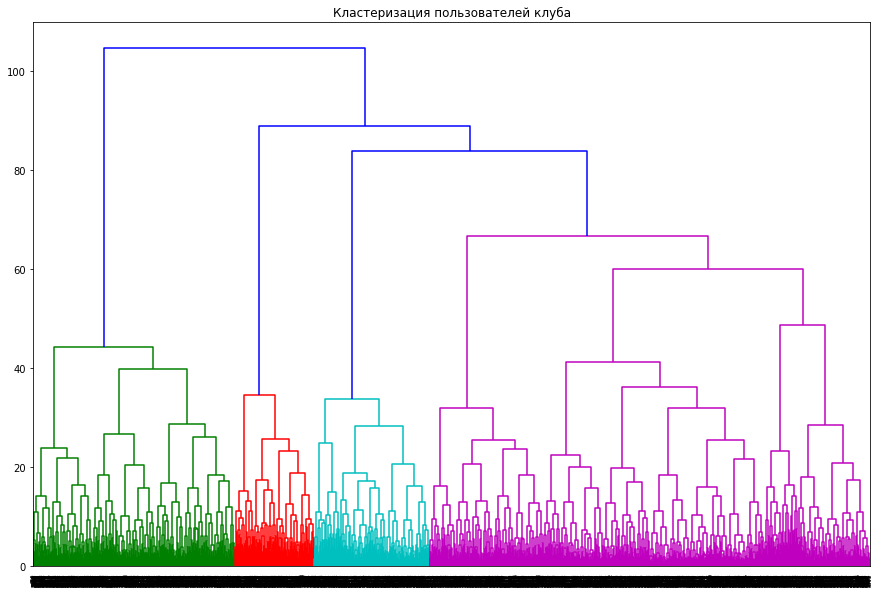

In [22]:
linked = linkage(X_sc, method = 'ward')
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Кластеризация пользователей клуба')
plt.show()

Дендограмма явно выделяет не менее 4 основных кастера.

### Обучение модели на основании алгоритма K-Means

Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов. Согласно ТЗ выделим 5 кластеров.

In [23]:
# задаём число кластеров, равное 5
km = KMeans(n_clusters = 5, random_state=0) 
labels = km.fit_predict(X_sc)

# добавим номера кластеров в наш датафрейм
df['cluster_km'] = labels
df

gender  near_location  partner  friends  phone  contract_period  \
0          1              1        1        1      0                6   
1          0              1        0        0      1               12   
2          0              1        1        0      1                1   
3          0              1        1        1      1               12   
4          1              1        1        1      1                1   
...      ...            ...      ...      ...    ...              ...   
3995       1              1        1        0      1               12   
3996       0              1        0        0      1                1   
3997       1              1        1        1      1               12   
3998       0              1        1        1      1                6   
3999       1              0        1        0      0               12   

      group_visits  age  avg_charges  end_month  lifetime  avg_class_t  \
0                1   29    14.227470          5         3     0.020398   
1                1   31   113.202938         12         7     1.922936   
2                0   28   129.448479          1         2     1.859098   
3                1   33    62.669863         12         2     3.205633   
4                0   26   198.362265          1         3     1.113884   
...            ...  ...          ...        ...       ...          ...   
3995             0   33     2.406023         12         8     2.284497   
3996             1   29    68.883764          1         1     1.277168   
3997             0   28    78.250542         11         2     2.786146   
3998             0   32    61.912657          5         3     1.630108   
3999             1   30   178.861814         12         1     1.101832   

      avg_class_cm  churn  cluster_km  
0         0.000000      0           1  
1         1.910244      0           0  
2         1.736502      0           3  
3         3.357215      0           0  
4         1.120078      0           3  
...            ...    ...         ...  
3995      2.349070      0           0  
3996      0.292859      1           3  
3997      2.831439      0           0  
3998      1.596237      0           0  
3999      1.035270      0           1  

[4000 rows x 15 columns]

In [24]:
# узнаем количество клиентов вкаждом кластере
df.groupby(['cluster_km'])['gender'].count()

cluster_km
0    1011
1     385
2     505
3    1262
4     837
Name: gender, dtype: int64

Кластеры сильно отличаются по количеству клиентов, что нужно помнить при анализе.

### Средние значения признаков для кластеров 

In [25]:
df.groupby('cluster_km').mean().T

cluster_km                0           1           2           3           4
gender             0.502473    0.522078    0.495050    0.485737    0.560335
near_location      0.959446    0.862338    0.000000    1.000000    0.976105
partner            0.783383    0.470130    0.463366    0.350238    0.356033
friends            0.574679    0.306494    0.079208    0.240095    0.229391
phone              1.000000    0.000000    1.000000    1.000000    0.998805
contract_period   10.884273    4.787013    2.352475    1.948494    2.665472
group_visits       0.543027    0.425974    0.215842    0.341521    0.473118
age               29.980218   29.301299   28.477228   28.167987   30.127838
avg_charges      160.706969  143.957664  135.457501  131.622204  161.724258
end_month          9.950544    4.475325    2.198020    1.856577    2.455197
lifetime           4.738872    3.924675    2.809901    2.440571    4.896057
avg_class_t        1.983305    1.847220    1.660461    1.247634    2.851531
avg_class_cm       1.976225    1.716369    1.477324    1.012983    2.849473
churn              0.027695    0.267532    0.443564    0.514263    0.068100

In [26]:
cluster_features = df.groupby('cluster_km').mean().reset_index()
numeric_columns = cluster_features.drop(columns=['cluster_km']).columns
cluster_features.T.style.background_gradient(cmap='coolwarm', axis=1).set_precision(2)

**Описание кластеров:**

Самый большой отток показвает кластер 3 - 51,4%. Это клиенты с краткосрочными абонементами в от 1 до 3 мсяцев. Несмотря на то, что это люди, живущие недалеко от клуба, показатели частосты посещений в этом кластере самые низкие, а еще они редко посезают групповые тренировки и у них самый низкий средний возраст. Нужно помнить, что это самый многочисленный кластер.

Кластер 2 показал также высокий отток - более 44%. Все эти клиенты живут далеко, среди них меньше всех участников акции "приведи друга". Они реже всех других кластеров ходят на групповые, средний lifetime всего 2,8 месяцев.


В кластере 1 отток составляет 26,75%. Большинство клиентов кластера живут рядом, интересно, что никто из них не предоставил свой телефон для связи. Средний срок карты - 4,5 месяца.

Кластер 4 имеет маленький отток, всего 6,8%. Это самая возрастная группа - около 30 лет в среднем. Пости все живут рядом с клубом и часто ходят на групповые. Стабильно посещают тренировки 2,8 раз в неделю что на протяении всего периода, что в последний месяц. Тратят на доп услуги больше дургих кластеров и имеют самый длинный lifetime - 4,9.

Абсолютный рекордсмен по оставшимся клиентами - кластер 0. Отток здесь всего 2,7%! Интересно, что кластер практически равен по соотношению полов, пости все клиенты жувут рядом. Что особенно интересно - 78% членов клуба этого кластера - работники компаний-партнеров, при этом 57% пришли по рекомендации друга. Это люди с самыми длительными договорами - более 10 мсеяцев, они чаще всех посещают групповые тренировки и тренируются пости 2 раза в неделю - в среднем чаще, чем представители остальных кластеров.

Стоит визуализировать распределение признаков кластеров, чтобы увидеть картину более наглядно

### Распределение признаков кластера

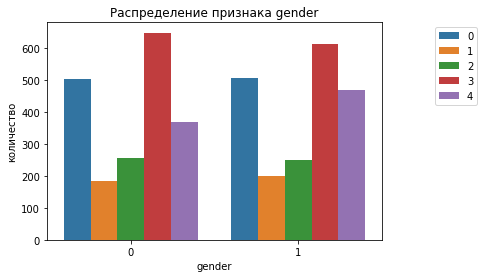

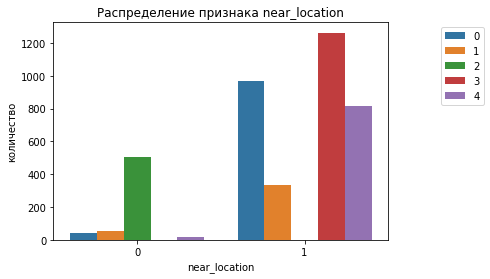

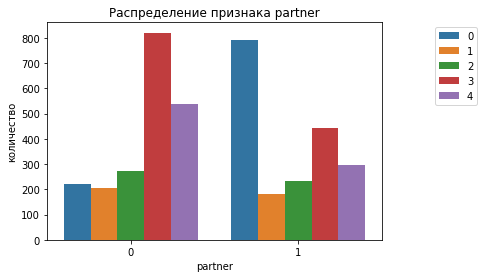

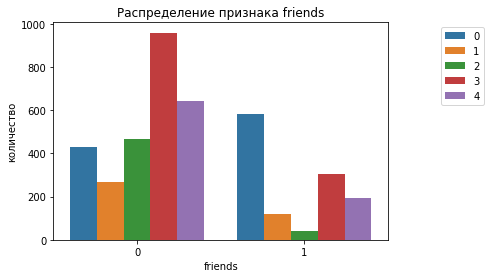

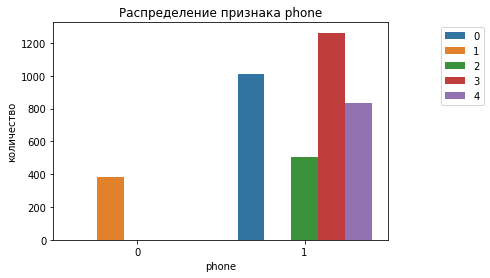

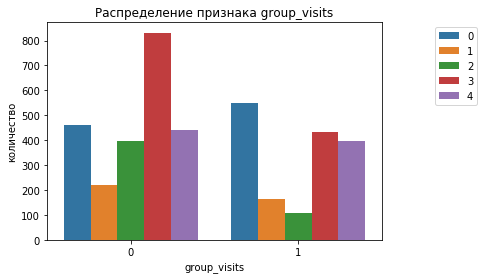

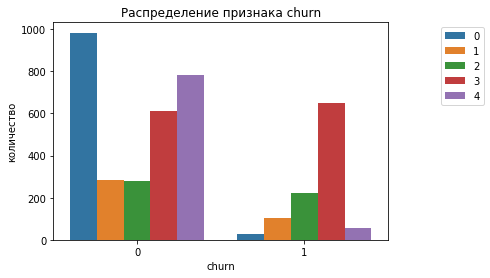

In [27]:
df[bool_columns] = df[bool_columns].astype('int')

# посмотрим на распределение булевых признаков
fig, ax = plt.subplots()
for column in bool_columns:
    plt.title("Распределение признака "+column)
    sns.countplot(data=df, x=column, hue='cluster_km')
    plt.xlabel(column)
    plt.ylabel("количество")
    plt.legend(bbox_to_anchor=(1.3, 1))
    plt.show()

Визуализация булевых признаков подтверждает наши наблюдения. Распределение полов допольно однородно, а вот признак расположения существенно отличается - клиенты, которые живут рядом реже попадают в отток, к тому же в визуализации видна интересная особенность - представители 2 кластера все живут далеко. В кластерах 3 и 4 больше всего партнеров и друзей и их отток ниже.

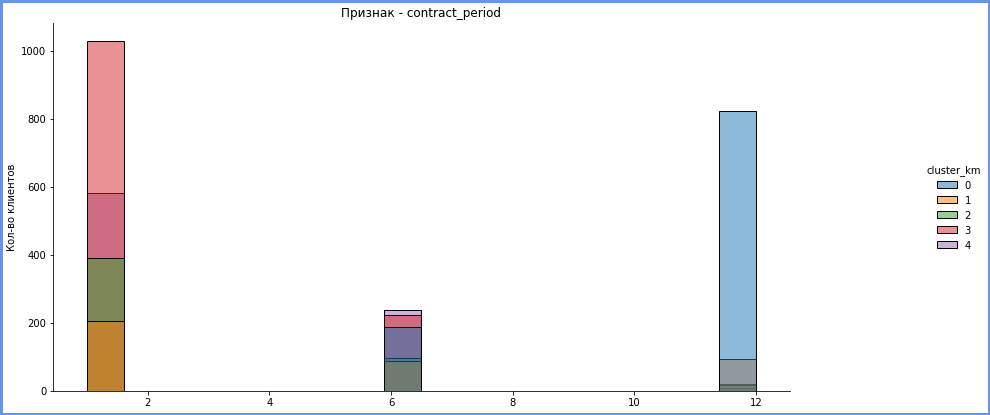

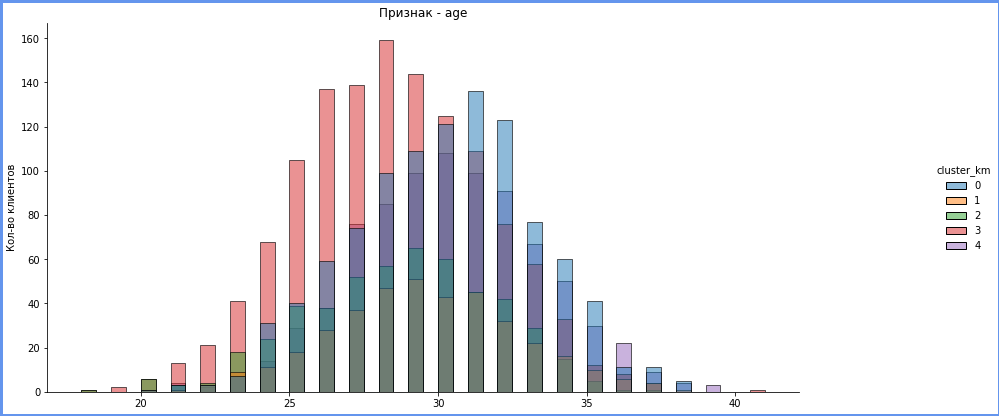

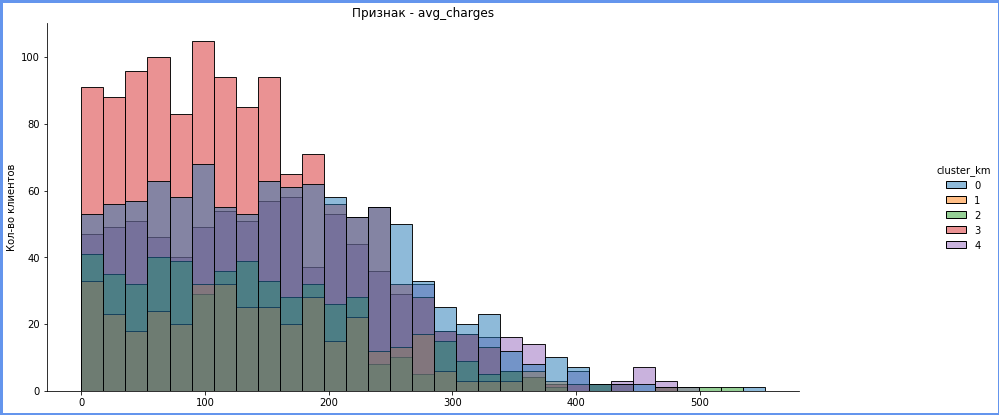

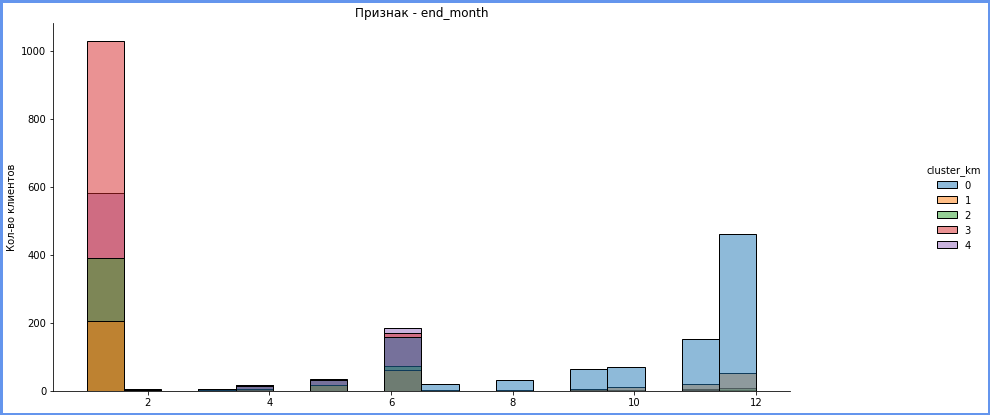

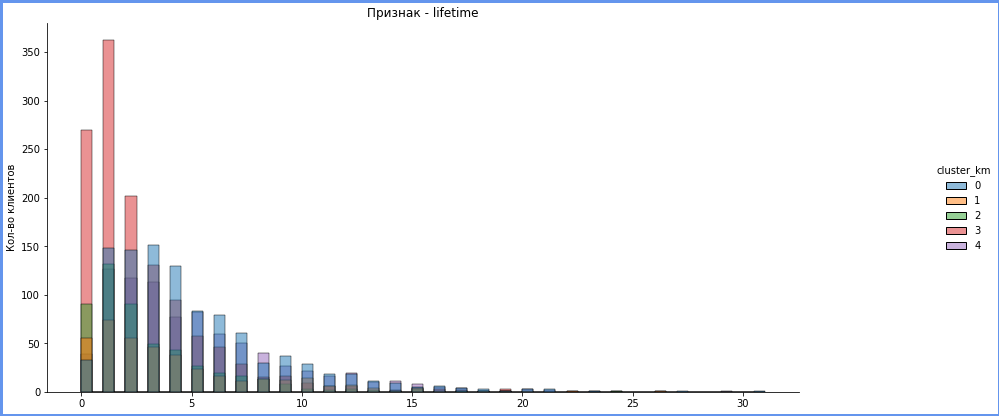

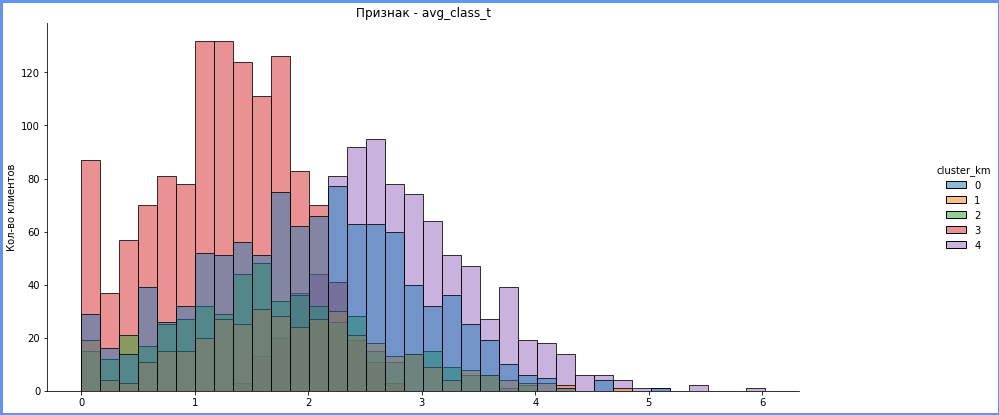

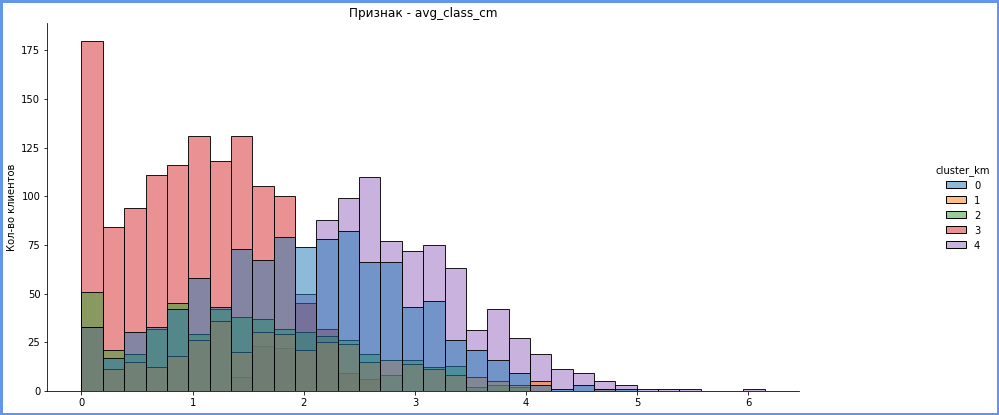

In [28]:
for column in dig_columns:
    dig = sns.displot(df, x=df[column], hue='cluster_km', palette="tab10", kind='hist')
    plt.title(f'Признак - {column}')
    plt.ylabel("Кол-во клиентов")
    plt.xlabel("")
    dig.fig.set_figwidth(15)
    dig.fig.set_figheight(6)
    dig.fig.patch.set_linewidth(5)
    dig.fig.patch.set_edgecolor('cornflowerblue')

Числовые признаки не менее интересны. Они показывают, что чаще всего карты продаются на 1,6 и 12 месяцев. Кластер 1 наиболее молодой, а кластер 0 - возрастной, а еще у кластера 0 осталось больше всего времени до конца абонемента - более 6 месяцев. 0 и 4 кластеры имеют самый длительный lifetime. Чаще всего на тренировки ходят 0 и 4 кластеры.

### Доля оттока по кластерам

Для каждого полученного кластера посчитаем долю оттока.

In [29]:
churn_cl = df.query('churn==1').groupby('cluster_km')['churn'].count() / df.query('churn==1')['churn'].count()
churn_cl

cluster_km
0    0.026390
1    0.097078
2    0.211122
3    0.611687
4    0.053723
Name: churn, dtype: float64

In [30]:
# визуализируем отток по кластерам
fig = go.Figure(data=[go.Pie(labels=churn_cl.index, values=churn_cl.values, title='Доли оттока в кластерах')]);
fig.show();

Мы видим, что самыми надежными можно назвать 0 и 4 кластеры, у которых ушли лишь 2,64% и 5,37% соответственно. Самый большой отток в 3 кластере - 61,2%. Представители 1 кластера уходят всего в 9,7% случаев. Второй кластер - середнячки, они живут далеко и ходят на тренировки редко, потому и часто бросают занятия.

## Общие выводы и рекомендации

В ходе работы над проектом были изучены и обработаны данные по 4 тысячам пользователей сети фитнес-центров «Культурист-датасаентист». Проведена предобработки и анализ данных, пропусков и дубликатов не обнаружено, данные целостные, поэтому удалось провести исследование на всем объеме датасета.

Был проведен анализ средних значений и построена матрица корреляции признаков клиентов: 84,5% посетителей живут рядом, при этом 48,6% – это работники фирм-партнеров, а порядка 30% пришли по акции «приведи друга». Средний срок абонементов 4,6 месяцев, при этом компании интереснее, чтобы покупали долгосрочные карты на 12 и более месяцев. Средний возраст клиентов 29 лет. Средняя частота посещений 1,87 раз в неделю. Средний отток -26,5%. Интересно, что в большинстве своем признаки коррелируют мало, видна зависимость только между близкими признаками – частотой тренировок в месяц и всего, сроком контракта и количеством месяцев до конца договора.

Были применены две модели прогнозирования оттока на основе логической регрессии и случайного леса. Показатели у логистической регрессии немного выше – доля правильных ответов 0,922, точность 0,854, полнота 0,828. Проведена стандартизация данных, кластеризация клиентов и изучено распределение признаков для каждого из кластеров, который помогли создать портрет идеального клиента. Согласно данным, «победил» кластер 0, который показал самый низкий уровень оттока 2,7%! Почти все клиенты этой группы живут рядом, 78% из них - работники компаний-партнеров, это люди с самыми длительными договорами - более 10 месяцев, и они чаще всех посещают групповые тренировки, чем представители остальных кластеров.

Анализ помог определить основные черты необходимых фитнес-центру клиентов:

люди в возрасте 30+,

проживающие или работающие рядом с клубом,

имеющие длительный (годовой) абонемент

и коллег или друзей, являющихся также членами клуба.

Наличие знакомых, которые тоже ходят в этот же клуб – залог более частых посещений групповых занятий, на которые многие ходят «за компанию» вместе с знакомыми. Именно на этих основаниях стоит строить маркетинговую стратегию: привлекать больше компаний-партнеров, находящихся поблизости, предлагать им дополнительные групповые скидки на абонементы 12 месяцев +, позволять формировать график тренировок закрытыми группами (только сотрудники одной организации в соответствии с графиком их работы).

С учетом возраста посетителей стоит предусмотреть специальные программы для сегмента 30+, а также дать скидки на семейные посещения живущим рядом, организовать детскую площадку, где могут находиться дети, пока занимаются родители так как по статистике средний возраст мамы в России 28,5 лет, то есть наш контингент – родители, у которых дети от 0 до 7 лет, которых не с кем оставить, чтобы пойти на тренировку.

Для снижения оттока текущих клиентов расширять возможности для групповых занятий, вводить новые группвые программы для молодежи (возможно игровые командные виды), работать над повышением частоты посещений, предложить льготные условия для продления красткосрочных абонементов.